## COSC 526 Final Project - Loan Default Prediction
---
Team 10: Tommy Smith, Kevin Houseman, Michael Kwarteng and Erik Johnson

## Data Description and Project Goals
---

Financial institutions employ machine learning algorithms to assess lender risk. This project focuses on identifying features in a loan portfolio dataset that could be used to predict whether the loan will default based on the loan structure itself (e.g., loan amount, interest rate, loan term, purpose), as well as demographic aspects of the borrower (e.g., age, income level, credit score, employment status, debt-to-income ratio, education level, marital status). Systematically identifying loans likely to default provides these institutions an efficient way to minimize the probability of default, and thereby prevent losses in capital and opportunity cost.

In raw form, this data contains 255,347 records and 18 columns including the target "Default" label (11.61% are labeled as defaulted). Data types include numerical and categorical (binary and multi-level). A variety of machine learning algorithms are used to identify significant features and predict default outcome. The exploration phase employs unsupervised algorithms Principal Component Analysis (PCA) and t-distributed Stochastic Neighbor Embedding (t-SNE) to reduce dimensionality and discover dominant features, as well as supervised algorithm Random Forest Classifier to identify feature importances.

The machine learning phase then explores three supervised classification algorithms: Logistic Regression, Random Forest, and Gradient Boosted Trees. Based on their intial results, we then employ a model on the best performer (Random Forest) to make the prediction of default status. Overall, the Random Forest Classifier model was able to predict loan default status with 88.6% accuracy. More details are listed in the model evaluation and conclusion sections.

Source data: https://www.kaggle.com/datasets/nikhil1e9/loan-default

## Data Exploration


In [ ]:
# Installing PySpark on Colab (instructions found on https://colab.research.google.com/drive/1G894WS7ltIUTusWWmsCnF_zQhQqZCDOc#pyspark)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -c https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar -xvzf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark
!pip install nltk
!pip install pandas
!pip install numpy

import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

import findspark
findspark.init()

In [ ]:
# Load 'Loan Default' file from GitHub
!wget https://raw.githubusercontent.com/erikjohnson06/Data/refs/heads/main/loan_default.csv -O /content/loan_default.csv

# Loan classes for project
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler, MinMaxScaler, PCA
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler as SKStandardScaler
from sklearn.manifold import TSNE


In [ ]:
# Define Schema
loan_schema = StructType([
    StructField('LoanID',       StringType(), nullable=True),
    StructField('Age',    IntegerType(), nullable=True),
    StructField('Income',    IntegerType(), nullable=True),
    StructField('LoanAmount',    IntegerType(), nullable=True),
    StructField('CreditScore', IntegerType(), nullable=True),
    StructField('MonthsEmployed',   IntegerType(), nullable=True),
    StructField('NumCreditLines',     IntegerType(), nullable=True),
    StructField('InterestRate',    FloatType(), nullable=True),
    StructField('LoanTerm',      IntegerType(), nullable=True),
    StructField('DTIRatio',      FloatType(), nullable=True),
    StructField('Education',      StringType(), nullable=True),
    StructField('EmploymentType',      StringType(), nullable=True),
    StructField('MaritalStatus',      StringType(), nullable=True),
    StructField('HasMortgage',      StringType(), nullable=True),
    StructField('HasDependents',      StringType(), nullable=True),
    StructField('LoanPurpose',      StringType(), nullable=True),
    StructField('HasCosigner',      StringType(), nullable=True),
    StructField('Default',      IntegerType(), nullable=True)
])

# Create a SparkSession
spark = SparkSession.builder.master("local[*]").appName("Team10FinalProject") \
    .config("spark.python.worker.reuse", "true") \
    .config("spark.python.worker.faulthandler.enabled", "true") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.sql.shuffle.partitions", "10") \
.getOrCreate()

# Load loan data with escaped columns (CSV uploaded to Colab files)
df = spark.read.option("header", True) \
               .option("quote", '"') \
               .option("escape", '"') \
               .csv(path='/content/loan_default.csv', schema=loan_schema)


 Schema
root
 |-- LoanID: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Income: integer (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- MonthsEmployed: integer (nullable = true)
 |-- NumCreditLines: integer (nullable = true)
 |-- InterestRate: float (nullable = true)
 |-- LoanTerm: integer (nullable = true)
 |-- DTIRatio: float (nullable = true)
 |-- Education: string (nullable = true)
 |-- EmploymentType: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- HasMortgage: string (nullable = true)
 |-- HasDependents: string (nullable = true)
 |-- LoanPurpose: string (nullable = true)
 |-- HasCosigner: string (nullable = true)
 |-- Default: integer (nullable = true)


 Description/statitics of raw data
+-------+----------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+----------------

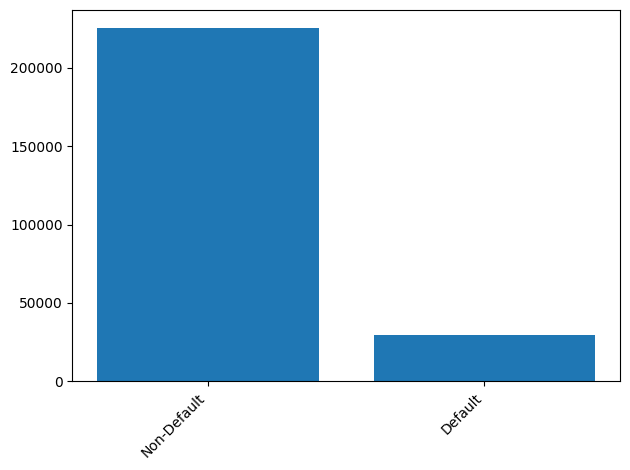

In [ ]:
# Exploratory analysis
print("\n Schema")
df.printSchema()

print("\n Description/statistics of raw data")
df.describe().show()

print("\n First 5 rows of raw data")
df.show(5, truncate=False)

pdf = df.toPandas()
print("\n Missing values: ", pdf.isnull().sum())
print("\n Duplicated values: ", pdf.duplicated().sum())

total_loan_count = df.count()
dflt_loan_count = df.where(df["Default"] == 1).distinct().count()
non_dflt_loan_count = df.where(df["Default"] == 0).distinct().count()
dflt_ratio = (dflt_loan_count / total_loan_count) * 100

print(f"\n Total number of loans: {total_loan_count}")
print(f"\n Number of defaulted loans: {dflt_loan_count}")
print(f"\n Number of non-defaulted loans: {non_dflt_loan_count}")
print(f"\n Percentage of defaulted loans: {dflt_ratio:.2f}%")

# Plot chart comparing total number of defaults vs non-defaults
plt.bar(["Non-Default", "Default"], [non_dflt_loan_count, dflt_loan_count])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

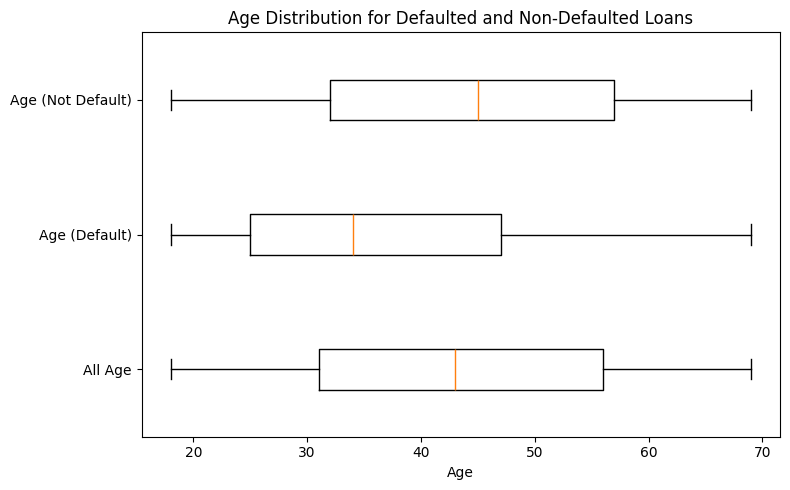

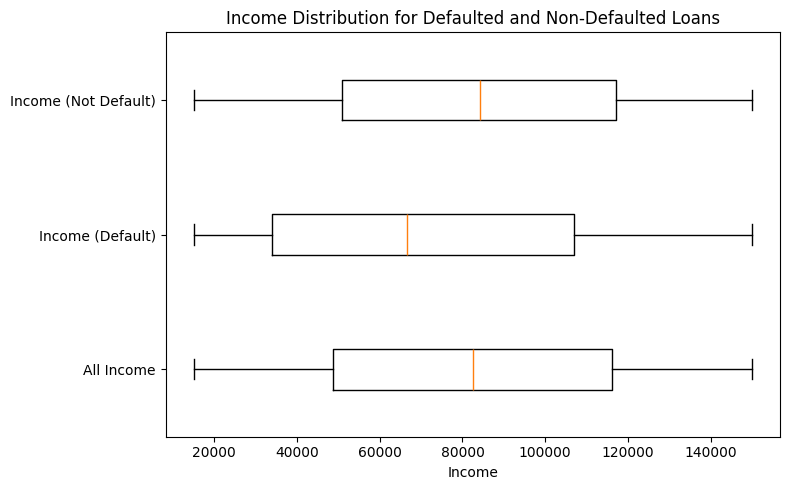

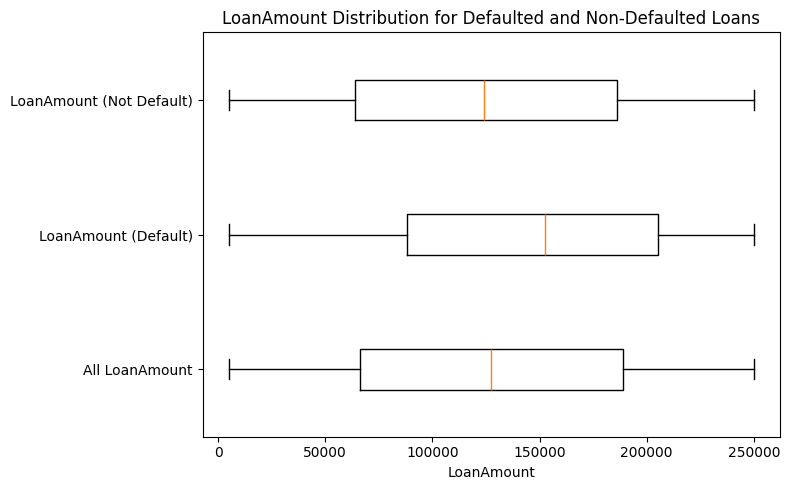

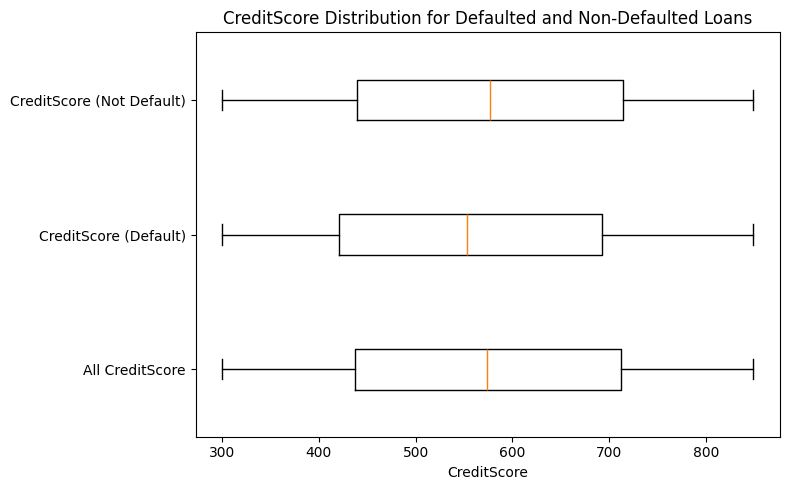

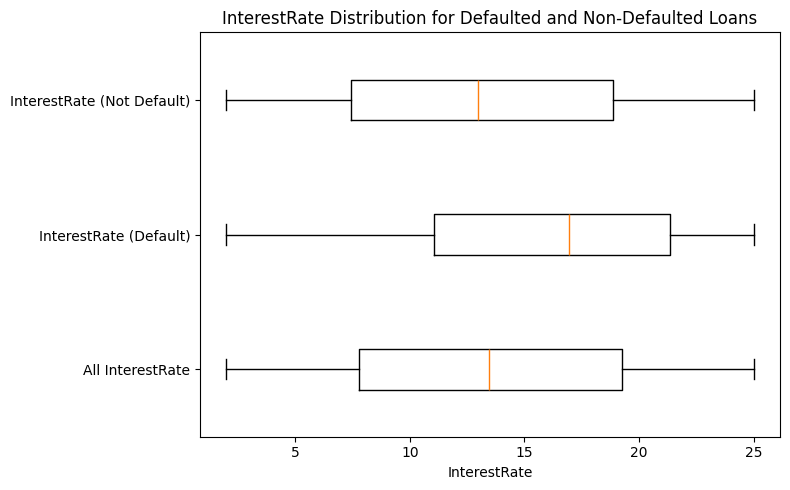

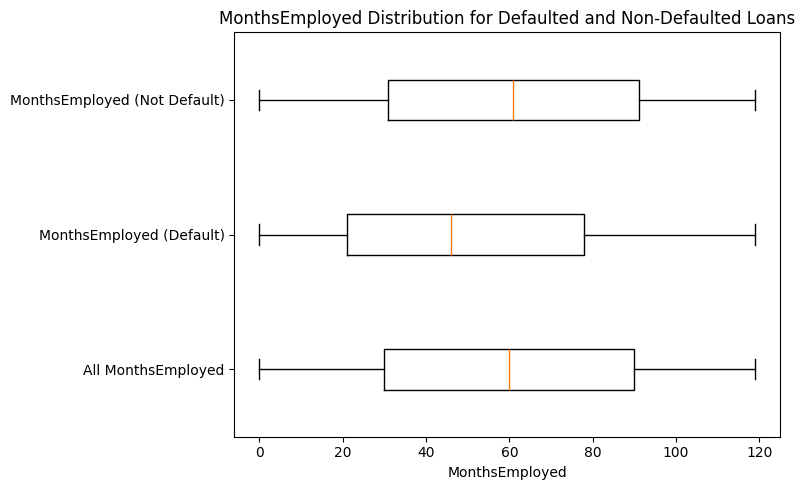

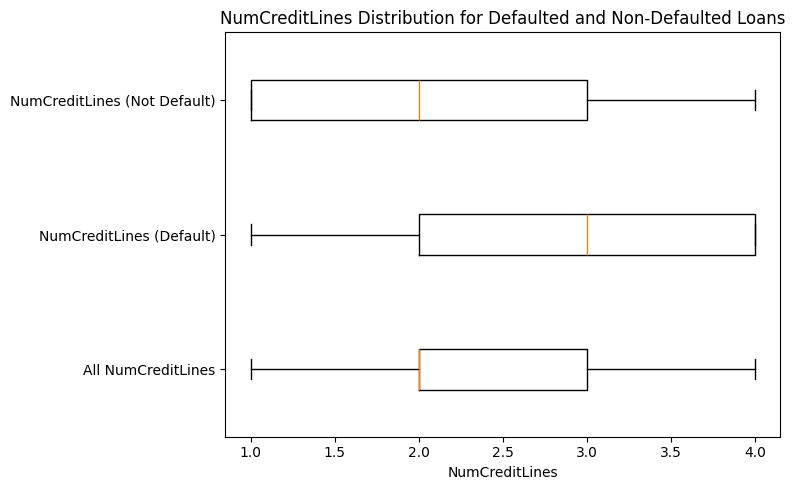

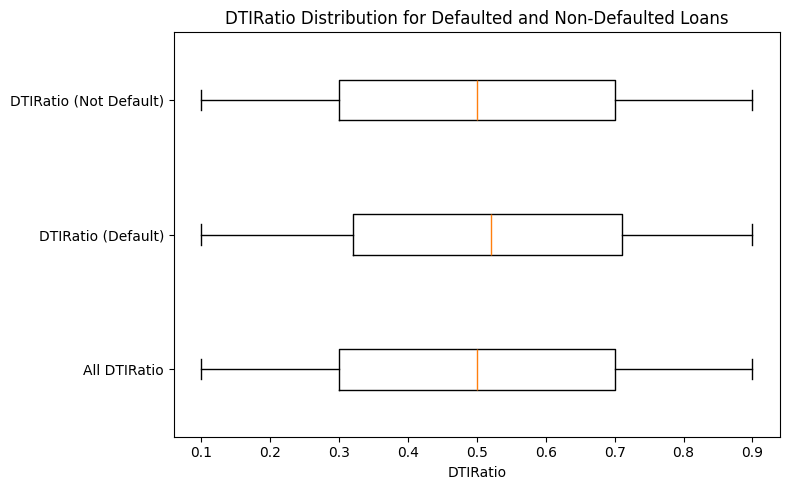

In [ ]:
# Visualize some of the suspected significant features comparing overall data against those who have defaulted and those who have not.
df_defaulted = df.where(df["Default"] == 1)
df_not_defaulted = df.where(df["Default"] == 0)

# Graph Boxplots of suspected features
numercial_features = ["Age", "Income", "LoanAmount", "CreditScore", "InterestRate", "MonthsEmployed", "NumCreditLines", "DTIRatio"]
categorical_features = ["HasMortgage", "HasDependents", "HasCosigner", "Education", "EmploymentType", "MaritalStatus", "LoanPurpose"]

for ftr in numercial_features:

  pdf_feature_all = df.select(ftr).toPandas()
  pdf_feature_defaulted = df_defaulted.select(ftr).toPandas()
  pdf_feature_not_defaulted = df_not_defaulted.select(ftr).toPandas()

  combined = [pdf_feature_all[ftr].values, pdf_feature_defaulted[ftr].values, pdf_feature_not_defaulted[ftr].values]

  # Plot all data, outliers, and normalized values in the same graph
  plt.figure(figsize=(8, 5))
  plt.boxplot(combined, tick_labels=['All ' + ftr, ftr + ' (Default)', ftr + ' (Not Default)'], vert=False)
  plt.xlabel(ftr)
  plt.title(ftr + ' Distribution for Defaulted and Non-Defaulted Loans')
  plt.tight_layout()
  plt.show()
  print("\n")

Categorical Comparison: Non-Default vs Defaulted


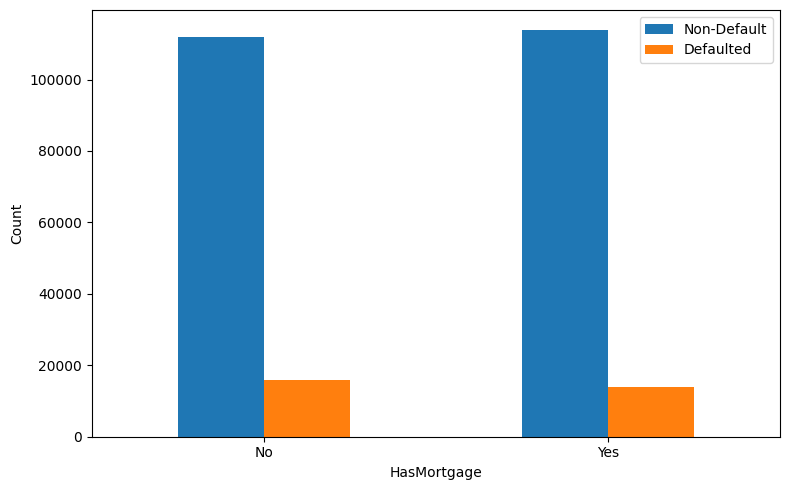

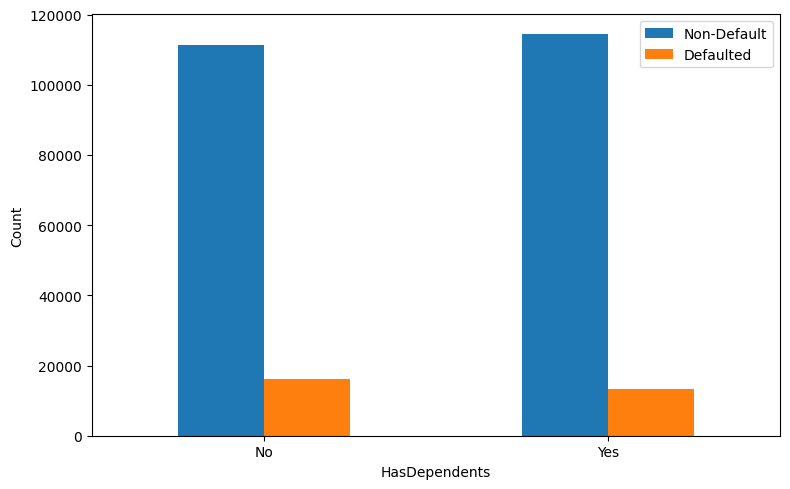

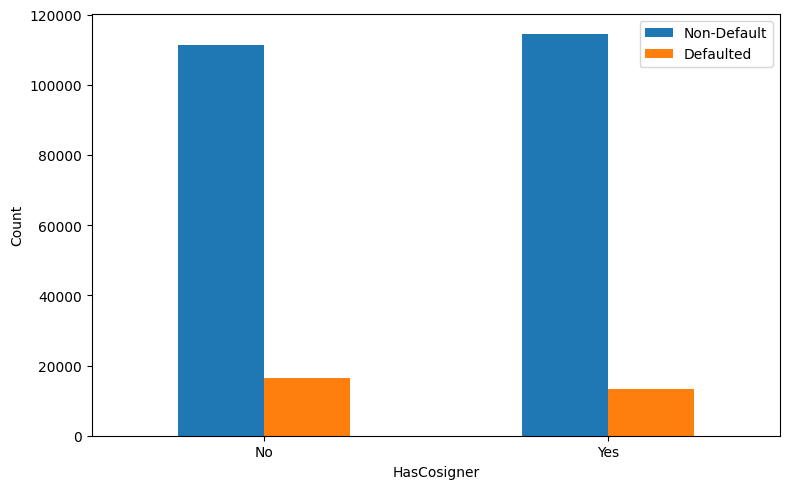

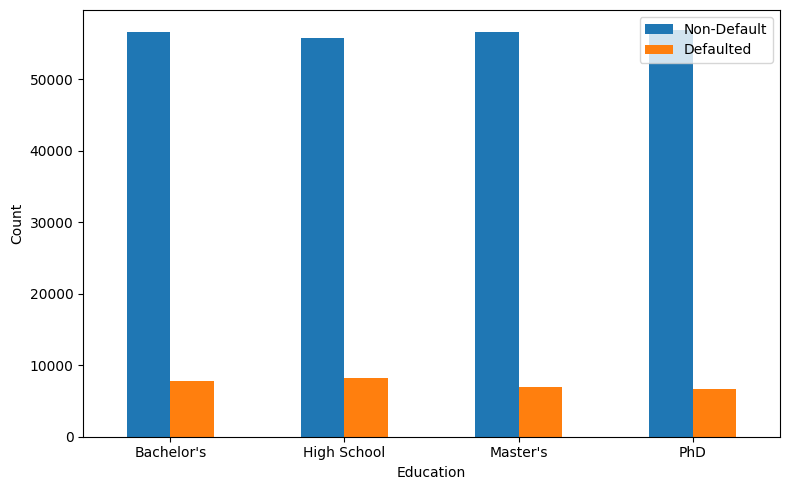

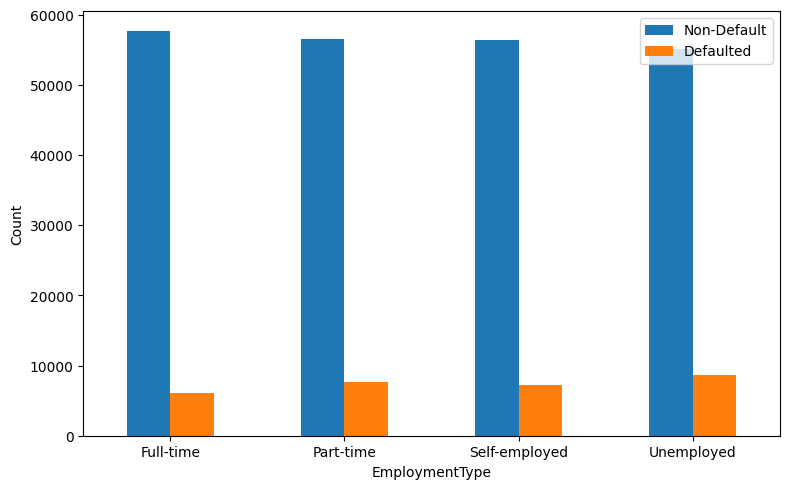

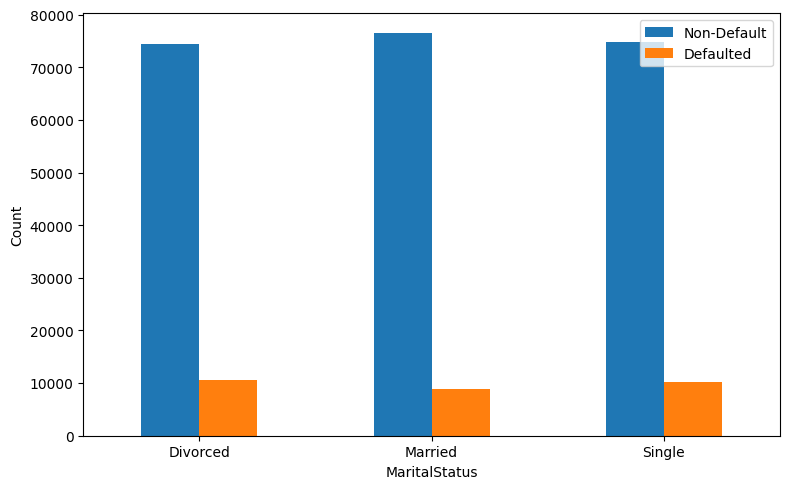

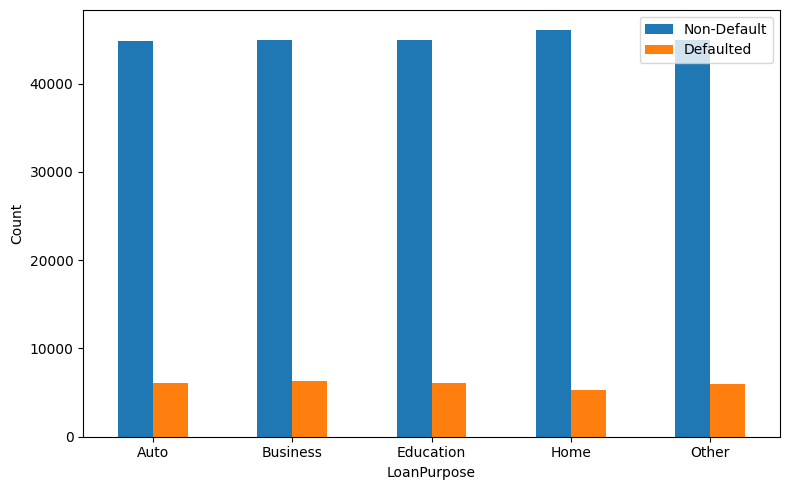

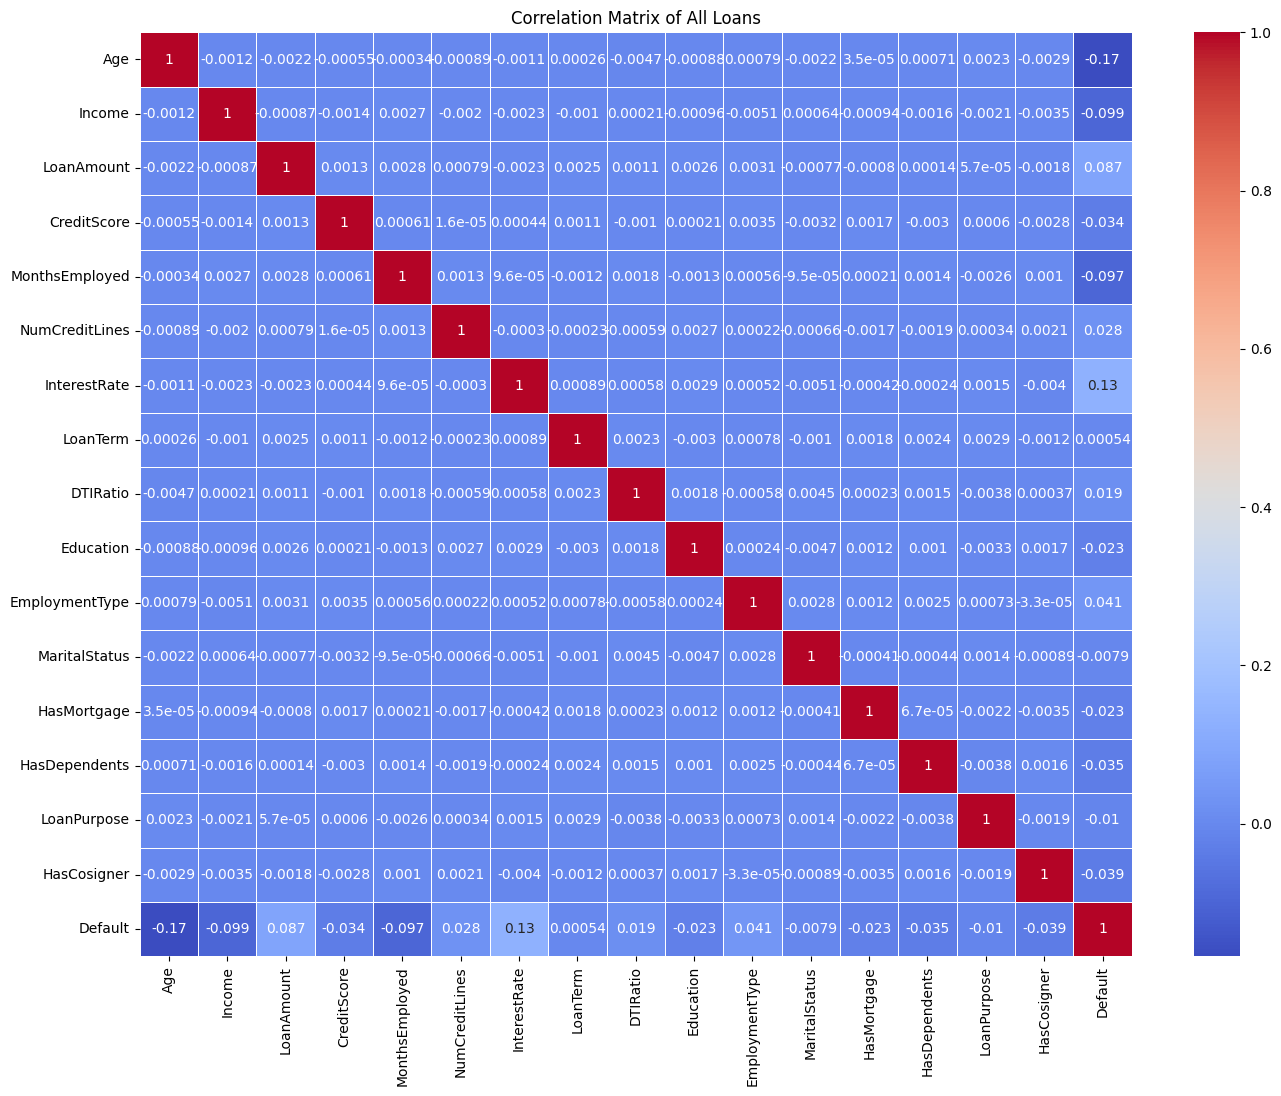

In [ ]:
# Categorical Plotting
pdf_all_encoded = df.drop('LoanID').toPandas()
pdf_defaulted = df_defaulted.drop('LoanID', 'Default').toPandas()
pdf_not_defaulted = df_not_defaulted.drop('LoanID', 'Default').toPandas()

print("Categorical Comparison: Non-Default vs Defaulted")
for col in categorical_features:
    # print("\nDefaulted:")
    # print(pdf_defaulted[col].value_counts())
    # print("\nNon-defaulted:")
    # print(pdf_not_defaulted[col].value_counts())
    # print("----------------------------")

    # Encode categorical columns
    le = LabelEncoder()
    pdf_all_encoded[col] = le.fit_transform(pdf_all_encoded[col])

    # pdf_defaulted_encoded[col] = le.fit_transform(pdf_defaulted_encoded[col])
    # pdf_not_defaulted_encoded[col] = le.fit_transform(pdf_not_defaulted_encoded[col])

    pdf_cat = pd.DataFrame({'Non-Default': pdf_not_defaulted[col].value_counts(), 'Defaulted': pdf_defaulted[col].value_counts()})
    pdf_cat.plot(kind='bar', figsize=(8, 5))

    #plt.title(f"Categorical Comparison: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    print("\n")


# plt.figure(figsize=(16, 12))
# sns.heatmap(df_defaulted_encoded.corr(), annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix of Defaulted Loan Features')
# plt.show()

# plt.figure(figsize=(16, 12))
# sns.heatmap(df_not_defaulted_encoded.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Matrix of Non-Defaulted Loan Features')
# plt.show()

# Correlation Matrix
plt.figure(figsize=(16, 12))
sns.heatmap(pdf_all_encoded.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of All Loans')
plt.show()

Summary:

The dataset is comprised of 18 columns of the following types: <br/>
Integer: 8<br/>
Float: 2<br/>
String: 8 (4 multi-class categorical columns, 3 binary (Yes/No) columns, and 1 ID column)

No missing or duplicate values were found. <br/>

Defaulted loans appear to be more prevalent where the borrower:
* is younger
* has a lower income
* has been unemployed for a longer period of time
* has a lower credit score
* has a higher number of existing credit lines
* has a higher debt-to-income ratio


And, loans that have:
* higher amounts
* higher interest rates


The following features appear to have very little or no bearing on defaulting:
* whether the borrower has a cosigner
* whether the borrower has dependents
* whether the borrower has an existing mortgage
* purpose of the loan
* term of the loan


The following features appear to have some bearing to defaulting:
* education level (lower education has some correlation)
* marital status (divorced and single status have some correlation)

<br/>
According to the correlation matrix, the strongest factors correlating to defaulting are (in order):<br/>
1) interest rate <br/>
2) amount of the loan <br/>
3) employment type <br/>
4) number of existing credit lines <br/>
5) Debt-to-income ratio<br/>

## Data Preparation and Feature Engineering

Data preparation involves dropping unnecessary columns (e.g., loan ID is not useful here), and engineering a risk score based on debt-to-income ratio, interest rate and credit score. The debt-to-income ratio here differs from the DTIRatio in the dataset (i.e., the DTIRatio includes other debt the borrower has, not just the loan amount), but because of the possibility of introducing collinearity issues, DTIRatio is dropped here. As noted above, there are no missing or duplicated values in the dataset. Categorical columns are then indexed using StringIndexer and OneHotEncoder (in the case of multi-class categories), and values are scaled appropriately. Finally, a Pipeline is constructed for usage in the algorithms below.

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Compute global totals for WOE
total = df.count()
bad_total = df.filter(F.col("Default") == 1).count()
good_total = total - bad_total

def make_woe(df, cat_col, label_col="Default", suffix=""):
    stats = (
        df.groupBy(cat_col)
          .agg(
              F.sum(F.when(F.col(label_col) == 1,1).otherwise(0)).alias("bad"),
              F.sum(F.when(F.col(label_col) == 0,1).otherwise(0)).alias("good")
          )
          .withColumn("woe", F.log((F.col("good")/good_total) / (F.col("bad")/bad_total)))
    )
    return stats.select(cat_col, F.col("woe").alias(f"woe_{cat_col}{suffix}"))

# Generate WOE for LoanPurpose, EmploymentType, MaritalStatus
woe_purpose = make_woe(df, "LoanPurpose")
woe_employment = make_woe(df, "EmploymentType")
woe_marital = make_woe(df, "MaritalStatus")

# Join back and drop originals
for woe_df in [woe_purpose, woe_employment, woe_marital]:
    df = df.join(woe_df, on=woe_df.columns[0], how="left")
df = df.drop("LoanPurpose", "EmploymentType", "MaritalStatus")


In [ ]:
# Feature interactions
# Income-to-Loan Amount ratio
from pyspark.sql import functions as F

# Income-to-Loan Amount ratio
if 'Income' in df.columns and 'LoanAmount' in df.columns:
    df = df.withColumn('income_loan_ratio', F.col('Income') / (F.col('LoanAmount') + F.lit(1)))

# Credit Score × DTIRatio
if 'CreditScore' in df.columns and 'DTIRatio' in df.columns:
    df = df.withColumn('credit_dti_interaction', F.col('CreditScore') * F.col('DTIRatio'))

# WOE Employment × WOE Marital interaction
if 'woe_EmploymentType' in df.columns and 'woe_MaritalStatus' in df.columns:
    df = df.withColumn('woe_emp_marital_inter', F.col('woe_EmploymentType') * F.col('woe_MaritalStatus'))

In [ ]:
# Testing whether DTIRatio and Feature 'Risk Ratio' are too collinear
from pyspark.ml.stat       import Correlation
from pyspark.ml.feature    import VectorAssembler
from pyspark.sql.functions import col

# Create RiskScore here for testing
df = df.withColumn('RiskScore', (((df['LoanAmount'] / df['Income']) * df['InterestRate']) / df['CreditScore'] ))

# Pearson correlation
pearson_corr = df.stat.corr("DTIRatio", "RiskScore")
print(f"Pearson corr(DTIRatio, RiskScore) = {pearson_corr:.4f}")

# 2-vector matrix
vec_assembler = VectorAssembler(
    inputCols=["DTIRatio", "RiskScore"],
    outputCol="corr_features"
)

df_vec = vec_assembler.transform(df.select("DTIRatio", "RiskScore")).select("corr_features")
corr_matrix = Correlation.corr(df_vec, "corr_features", method="pearson") \
                         .head()[0] \
                         .toArray()

print("Correlation matrix:\n"
      f"             DTIRatio  RiskScore\n"
      f"DTIRatio    {corr_matrix[0,0]:.4f}    {corr_matrix[0,1]:.4f}\n"
      f"RiskScore   {corr_matrix[1,0]:.4f}    {corr_matrix[1,1]:.4f}")

Pearson corr(DTIRatio, RiskScore) = 0.0004
Correlation matrix:
             DTIRatio  RiskScore
DTIRatio    1.0000    0.0004
RiskScore   0.0004    1.0000


In [ ]:
# Updated encoding pipeline & assembler
# Drop unique ID feature
df = df.drop("LoanID")

# Define features
numeric_features = [
    "Age", "Income", "LoanAmount", "CreditScore",
    "MonthsEmployed", "NumCreditLines", "InterestRate",
    "LoanTerm", "DTIRatio", "RiskScore"
]
woe_features = ["woe_LoanPurpose", "woe_EmploymentType", "woe_MaritalStatus"]
interaction_features = ["income_loan_ratio", "credit_dti_interaction", "woe_emp_marital_inter"]
multi_level = ["Education"]
binary_index = ["HasMortgage", "HasDependents", "HasCosigner"]

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

# Index & encode remaining categoricals
indexer = StringIndexer(
    inputCols=multi_level + binary_index,
    outputCols=[f"{c}_index" for c in multi_level + binary_index]
)
encoder = OneHotEncoder(
    inputCols=[f"{c}_index" for c in multi_level],
    outputCols=[f"{c}_encoded" for c in multi_level],
    dropLast=False
)

features_encoded = numeric_features + woe_features + interaction_features + [f"{c}_encoded" for c in multi_level] + [f"{c}_index" for c in binary_index]

assembler = VectorAssembler(inputCols=features_encoded, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

pipeline_stages = [indexer, encoder, assembler, scaler]

In [ ]:
# PCA Analysis

from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
import numpy as np

# Number of PCs to try
num_k = 8

# Define the PCA stage (takes 'scaled_features' → 'pca_features')
pca = PCA(k=num_k, inputCol="scaled_features", outputCol="pca_features")

# Build a single Pipeline: your existing preprocessing + PCA
#    (pipeline_stages was already defined as [indexer, encoder, assembler, scaler])
pca_pipeline = Pipeline(stages=pipeline_stages + [pca])

# Fit the pipeline on the *full* df so that 'scaled_features' is produced
model = pca_pipeline.fit(df)

# Transform to get principal components
pca_result = model.transform(df)

# Grab the fitted PCA model (it's the last stage)
pca_model = model.stages[-1]

# Compute explained variances and cumulative sum to auto-pick k
explained = np.array(pca_model.explainedVariance.toArray())
cum_explained = np.cumsum(explained)
optimal_k = int(np.searchsorted(cum_explained, 0.90) + 1)
print(f"Optimal k for ≥ 90% variance: {optimal_k}")

# Print out each PC’s variance
for i, var in enumerate(explained, start=1):
    print(f"PC{i}: {var:.4f}")

Optimal k for ≥90% variance: 9
PC1: 0.0927
PC2: 0.0840
PC3: 0.0581
PC4: 0.0580
PC5: 0.0579
PC6: 0.0522
PC7: 0.0462
PC8: 0.0439


Text(0.5, 1.0, 't-SNE of Loan Data')

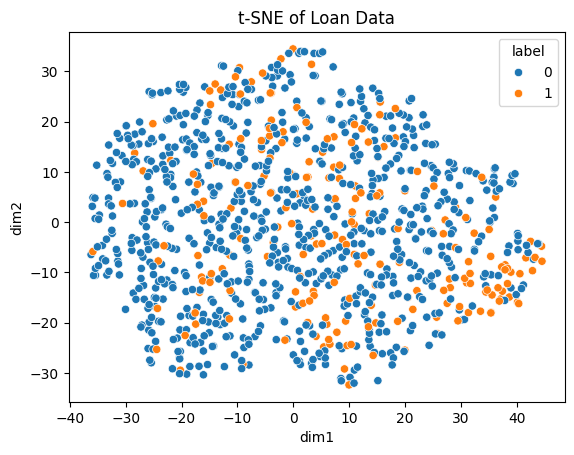

In [ ]:
# t-SNE Visualization (Smaller random sample for less congestion)

from sklearn.preprocessing import StandardScaler as SKStandardScaler
from sklearn.manifold       import TSNE

# Split & sample to control size
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
sample_tsne       = test_df.sample(False, 0.2, seed=42).limit(1000)

# Convert only numeric features to Pandas
X = sample_tsne.select(numeric_features).toPandas()
y = sample_tsne.select("Default").toPandas()

# Scale & project
X_scaled = SKStandardScaler().fit_transform(X)
X_tsne   = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
df_tsne = pd.DataFrame(X_tsne, columns=["dim1","dim2"])
df_tsne["label"] = y
sns.scatterplot(data=df_tsne, x="dim1", y="dim2", hue="label")
plt.title("t-SNE of Loan Data")

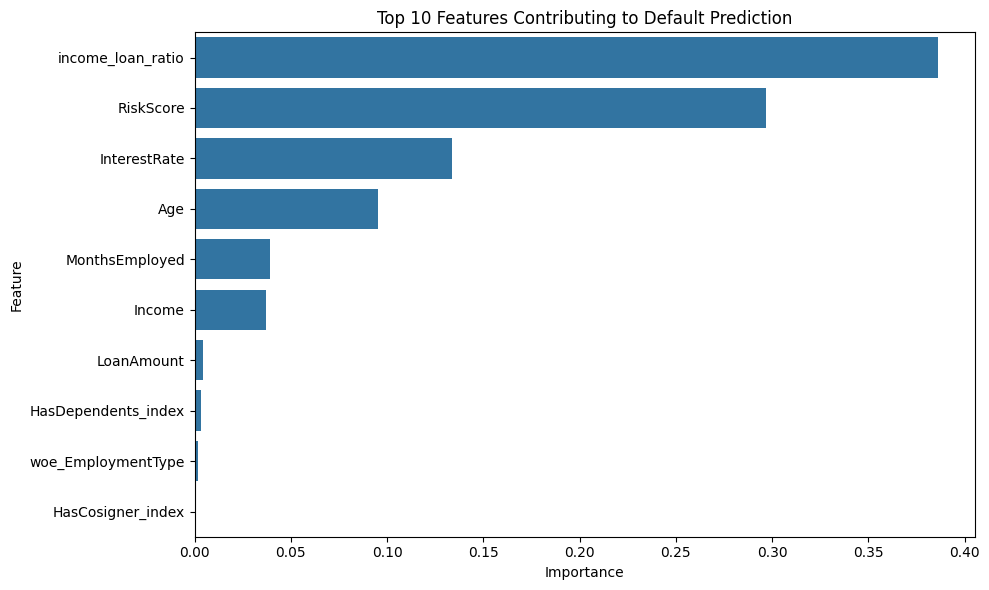

In [ ]:
# Have to change for some reason existing architecture isn't liking the new WOE variables for plotting altogether

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Train RF on the same pipeline_stages + classifier
rfc = RandomForestClassifier(labelCol="Default", featuresCol="scaled_features", seed=42)
rf_pipeline = Pipeline(stages=pipeline_stages + [rfc])
pipeline_model = rf_pipeline.fit(df)
rf_model = pipeline_model.stages[-1]       # the fitted RandomForestModel

# Grab feature names from the **features** column metadata
schema_sample = pipeline_model.transform(df.limit(1)).schema

# Spark stores attrs under "ml_attr" -> "attrs" on the assembler output
feat_meta = schema_sample["features"].metadata["ml_attr"]["attrs"]

# Flatten and sort by index
metadata_attributes = []
for attr_list in feat_meta.values():
    metadata_attributes.extend(attr_list)
metadata_attributes.sort(key=lambda x: x["idx"])

feature_names = [attr["name"] for attr in metadata_attributes]

# Build a Pandas DataFrame of importances
importances = rf_model.featureImportances.toArray()
importances_df = (
    pd.DataFrame({"Feature": feature_names, "Importance": importances})
      .sort_values("Importance", ascending=False)
)

# Plot the Top-10
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importances_df.head(10))
plt.title("Top 10 Features Contributing to Default Prediction")
plt.tight_layout()
plt.show()

## Machine Learning Algorithm Preparation and Tuning

Applying the following supervised algorithms for initial testing and exploration purposes:

- Random Forest Classifier
- Logisitic Regression
- Gradient Boosting Trees

In [ ]:
from pyspark.ml.tuning        import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation    import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.sql.functions    import when, col

# Split
trainDF, testDF = df.randomSplit([0.8, 0.2], seed=42)

# Inverse-frequency class weights on training set only
counts = trainDF.groupBy("Default").count().collect()
neg, pos = {r["Default"]: r["count"] for r in counts}[0], {r["Default"]: r["count"] for r in counts}[1]
total = neg + pos
w0, w1 = pos/total, neg/total # for inverse proportion
trainDF = trainDF.withColumn("classWeightCol",
                             when(col("Default") == 0, w0).otherwise(w1)
)

# Lastly Eval
evaluator = BinaryClassificationEvaluator(
    labelCol="Default", metricName="areaUnderROC"
)


In [ ]:
# Random Forest + Cross Val
from pyspark.ml.tuning        import TrainValidationSplit, ParamGridBuilder

#Sample Down
tuneDF = trainDF.sample(False, 0.2, seed=42).cache()

# Estimator and pipeline
rfc = RandomForestClassifier(
    labelCol="Default",
    featuresCol="scaled_features",
    weightCol="classWeightCol",
    seed=42
)
pipe_rf = Pipeline(stages=pipeline_stages + [rfc])

# Hyperparameter Grid
paramGrid_rf = (ParamGridBuilder()
    .addGrid(rfc.numTrees, [100, 300])
    .addGrid(rfc.maxDepth, [5, 10])
    .build()
)

# Train Validate Split 80/20
evaluator = BinaryClassificationEvaluator(labelCol="Default", metricName="areaUnderROC")
tvs = TrainValidationSplit(
    estimator=pipe_rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator,
    trainRatio=0.8,      # 80/20 split
    parallelism=1         # single-threaded
)


# Fit And Evluate
tvsModel = tvs.fit(tuneDF)
bestRF   = tvsModel.bestModel
predRF   = bestRF.transform(testDF)
auc_rf   = evaluator.evaluate(predRF)

print(f"RF (TrainValSplit) ROC AUC = {auc_rf:.4f}")

RF (TrainValSplit) ROC AUC = 0.7449


In [ ]:
# Log Reg
from pyspark.ml.evaluation    import BinaryClassificationEvaluator

# Log Reg Pipeline
lr      = LogisticRegression(
             labelCol="Default",
             featuresCol="scaled_features",
             weightCol="classWeightCol",
             maxIter=50
          )
pipe_lr = Pipeline(stages=pipeline_stages + [lr])

# Hyperparameter grid (smaller grid for speed)
paramGrid_lr = (
    ParamGridBuilder()
      .addGrid(lr.regParam,        [0.0, 0.1])
      .addGrid(lr.elasticNetParam, [0.0, 0.5])
      .build()
)

# TrainValidationSplit 80/20
evaluator = BinaryClassificationEvaluator(labelCol="Default", metricName="areaUnderROC")
tvs_lr = TrainValidationSplit(
    estimator=pipe_lr,
    estimatorParamMaps=paramGrid_lr,
    evaluator=evaluator,
    trainRatio=0.8,
    parallelism=1
)

# Fit & evaluate on full test set
tvsModel_lr = tvs_lr.fit(tuneDF)
bestLR      = tvsModel_lr.bestModel
predLR      = bestLR.transform(testDF)
auc_lr      = evaluator.evaluate(predLR)

print(f"Logistic Regression (TrainValSplit) ROC AUC = {auc_lr:.4f}")

Logistic Regression (TrainValSplit) ROC AUC = 0.7550


In [ ]:
# Simple Gradient Boosted Trees
from pyspark.ml.classification import GBTClassifier

#Pipeline
gbt = GBTClassifier(labelCol="Default", featuresCol="scaled_features", weightCol="classWeightCol", seed=42)
pipe_gbt = Pipeline(stages=pipeline_stages + [gbt])

#Hyperparameter grid
paramGrid_gbt = (ParamGridBuilder()
    .addGrid(gbt.maxIter, [50])
    .addGrid(gbt.maxDepth, [5, 10])
    .addGrid(gbt.stepSize, [0.05, 0.1])
    .build()
)

#Train Val SSplit
tvs_gbt = TrainValidationSplit(estimator=pipe_gbt, estimatorParamMaps=paramGrid_gbt, evaluator=evaluator, trainRatio=0.8, parallelism=1)

#Fit
tvsModel_gbt = tvs_gbt.fit(tuneDF)
bestGBT = tvsModel_gbt.bestModel
predGBT = bestGBT.transform(testDF)
auc_gbt = evaluator.evaluate(predGBT)

print(f"GBT (TrainValSplit) ROC AUC = {auc_gbt:.4f}")

GBT (TrainValSplit) ROC AUC = 0.7431


In [ ]:

# Compare RF, LR & GBT Metrics
from pyspark.mllib.evaluation import MulticlassMetrics

def show_metrics(predictions, label_col="Default"):

    # Build RDD[(prediction, label)] with floats
    pred_label_rdd = (
        predictions
          .select("prediction", label_col)
          .rdd
          .map(lambda r: (float(r[0]), float(r[1])))
    )

    metrics = MulticlassMetrics(pred_label_rdd)

    # Confusion matrix
    cm = metrics.confusionMatrix().toArray()
    print("Confusion Matrix:\n", cm)

    # Precision, recall, F1 for positive class (1.0)
    pos = 1.0
    print(f"Precision (pos=1): {metrics.precision(pos):.3f}")
    print(f"Recall    (pos=1): {metrics.recall(pos):.3f}")
    print(f"F1 Score  (pos=1): {metrics.fMeasure(pos):.3f}")
    print("-" * 30)

print("Random Forest Metrics")
show_metrics(predRF)

print("Logistic Regression Metrics")
show_metrics(predLR)

print("Gradient-Boosted Trees Metrics")
show_metrics(predGBT)


Random Forest Metrics


/content/spark-3.5.1-bin-hadoop3/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
 [[37253.  7937.]
 [ 2880.  3062.]]
Precision (pos=1): 0.278
Recall    (pos=1): 0.515
F1 Score  (pos=1): 0.361
------------------------------
Logistic Regression Metrics
Confusion Matrix:
 [[31218. 13972.]
 [ 1849.  4093.]]
Precision (pos=1): 0.227
Recall    (pos=1): 0.689
F1 Score  (pos=1): 0.341
------------------------------
Gradient-Boosted Trees Metrics
Confusion Matrix:
 [[32599. 12591.]
 [ 2146.  3796.]]
Precision (pos=1): 0.232
Recall    (pos=1): 0.639
F1 Score  (pos=1): 0.340
------------------------------


# Random Forest Model with focus on total Accuracy
Pre compute, cache features.

Coarse-to-Fine tune in smaller samples in attempt to mitigate resource usage

a. Coarse grid on 10% of train

b. Fine grid on another smalll slice ~20-30%

Final training on the full 80% training data

In [ ]:
from pyspark.ml import Pipeline

# Split into train/test once
trainDF, testDF = df.randomSplit([0.8, 0.2], seed=42)

# pipeline of *only* preprocessing stages
prep_pipeline = Pipeline(stages=pipeline_stages)

# Fit & transform ONCE
prep_model     = prep_pipeline.fit(trainDF)
train_prepped  = prep_model.transform(trainDF).select("scaled_features","Default").cache()
test_prepped   = prep_model.transform(testDF).select("scaled_features","Default").cache()


In [ ]:
# Coarse grid on 10% train_prepped
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning       import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation   import BinaryClassificationEvaluator

small = train_prepped.sample(False, 0.1, seed=42).cache()

rfc = RandomForestClassifier(labelCol="Default", featuresCol="scaled_features", seed=42)
paramGrid_coarse = (ParamGridBuilder()
    .addGrid(rfc.numTrees, [50, 200])
    .addGrid(rfc.maxDepth, [5, 15])
    .build()
)

tvs_coarse = TrainValidationSplit(
    estimator=rfc,
    estimatorParamMaps=paramGrid_coarse,
    evaluator=BinaryClassificationEvaluator(labelCol="Default", metricName="areaUnderROC"),
    trainRatio=0.8,
    parallelism=2
)

tvs_model_coarse = tvs_coarse.fit(small)
best_rf_coarse   = tvs_model_coarse.bestModel

# <-- NO PARENTHESES HERE
best_numTrees  = best_rf_coarse.getNumTrees
best_maxDepth  = best_rf_coarse.getMaxDepth

print(f"Coarse best: numTrees={best_numTrees}, maxDepth={best_maxDepth}")


Coarse best: numTrees=200, maxDepth=<bound method _DecisionTreeParams.getMaxDepth of RandomForestClassificationModel: uid=RandomForestClassifier_617c75d55640, numTrees=200, numClasses=2, numFeatures=23>


In [ ]:
# Fine Grid on 20% (will up to 30% if it doesn't take too long)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning       import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation   import BinaryClassificationEvaluator

best_numTrees  = best_rf_coarse.getOrDefault(rfc.numTrees)
best_maxDepth  = best_rf_coarse.getOrDefault(rfc.maxDepth)

medium = train_prepped.sample(False, 0.2, seed=43).cache()

rfc2 = RandomForestClassifier(
    labelCol="Default",
    featuresCol="scaled_features",
    seed=42
)

paramGrid_fine = (
    ParamGridBuilder()
      .addGrid(rfc2.numTrees,    [
          int(best_numTrees * 0.8),
          best_numTrees,
          int(best_numTrees * 1.2)
      ])
      .addGrid(rfc2.maxDepth,    [
          max(1, best_maxDepth - 3),
          best_maxDepth,
          best_maxDepth + 3
      ])
      .build()
)

tvs_fine = TrainValidationSplit(
    estimator=rfc2,
    estimatorParamMaps=paramGrid_fine,
    evaluator=BinaryClassificationEvaluator(
        labelCol="Default", metricName="areaUnderROC"
    ),
    trainRatio=0.8,
    parallelism=2
)

tvs_model_fine = tvs_fine.fit(medium)
best_rf_fine   = tvs_model_fine.bestModel

best_numTrees  = best_rf_fine.getOrDefault(rfc2.numTrees)
best_maxDepth  = best_rf_fine.getOrDefault(rfc2.maxDepth)

print(f"Fine best: numTrees={best_numTrees}, maxDepth={best_maxDepth}")

Fine best: numTrees=200, maxDepth=8


In [ ]:
# Final training on 80% of data using prior optimal parameters

final_rfc = RandomForestClassifier(
    labelCol="Default",
    featuresCol="scaled_features",
    numTrees=best_numTrees,
    maxDepth=best_maxDepth,
    seed=42
)
final_model = final_rfc.fit(train_prepped)   # note: on train_prepped, not raw df

# Evaluate once on test_prepped:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="Default", metricName="areaUnderROC")
auc_final = evaluator.evaluate(final_model.transform(test_prepped))
print(f"Final RF (80% train) ROC AUC = {auc_final:.4f}")


Final RF (80% train) ROC AUC = 0.7386


In [ ]:
# Random Forest Model prioritizing Recall
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning       import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation   import MulticlassClassificationEvaluator
from pyspark.sql.functions   import when, col
from pyspark.mllib.evaluation import MulticlassMetrics

# Sample 20% for tuning & compute class weights
sample_tune = train_prepped.sample(False, 0.2, seed=42).cache()
counts      = sample_tune.groupBy("Default").count().collect()
neg_count   = next(r["count"] for r in counts if r["Default"]==0)
pos_count   = next(r["count"] for r in counts if r["Default"]==1)
total       = neg_count + pos_count
w0, w1      = pos_count/total, neg_count/total

weighted_tune = sample_tune.withColumn(
    "classWeightCol",
    when(col("Default")==0, w0).otherwise(w1)
).cache()

# Define RF with weightCol (no full pipeline needed)
rfc_rec = RandomForestClassifier(
    labelCol="Default",
    featuresCol="scaled_features",
    weightCol="classWeightCol",
    seed=42
)

# Tiny hyperparameter grid (2×2)
paramGrid = (
    ParamGridBuilder()
      .addGrid(rfc_rec.numTrees, [100, 200])
      .addGrid(rfc_rec.maxDepth, [5, 10])
      .build()
)

# Tune with TrainValidationSplit optimizing **recall** on class=1
recall_eval = MulticlassClassificationEvaluator(
    labelCol="Default",
    predictionCol="prediction",
    metricName="recallByLabel",
    metricLabel=1.0
)

tvs_rec = TrainValidationSplit(
    estimator           = rfc_rec,
    estimatorParamMaps  = paramGrid,
    evaluator           = recall_eval,
    trainRatio          = 0.8,
    parallelism         = 1
)

model_rec   = tvs_rec.fit(weighted_tune)
best_rf_rec = model_rec.bestModel

# Score on held‐out 20%
pred_rec = best_rf_rec.transform(test_prepped)

# Confusion matrix + class metrics
rdd     = pred_rec.select("prediction","Default").rdd.map(lambda r: (float(r[0]), float(r[1])))
metrics = MulticlassMetrics(rdd)
cm      = metrics.confusionMatrix().toArray()
prec1   = metrics.precision(1.0)
rec1    = metrics.recall(1.0)
f1_1    = metrics.fMeasure(1.0)

# Overall accuracy
acc_eval = MulticlassClassificationEvaluator(
    labelCol="Default",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = acc_eval.evaluate(pred_rec)

# Display results
print("Confusion Matrix:\n", cm)
print(f"Precision (pos=1): {prec1:.3f}")
print(f"Recall    (pos=1): {rec1:.3f}")
print(f"F1 Score  (pos=1): {f1_1:.3f}")
print(f"Overall accuracy : {accuracy:.3f}")

Confusion Matrix:
 [[32780. 12410.]
 [ 2218.  3724.]]
Precision (pos=1): 0.231
Recall    (pos=1): 0.627
F1 Score  (pos=1): 0.337
Overall accuracy : 0.714


In [ ]:
# Trimmed full Rf mdoel with parameter tuning and CV
#Will not run on colab, still too resource heavy. 6000seconds run time before spark died


'''
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

# Oversample the minority class (Default=1)
posDF = trainDF.filter("Default = 1")
negDF = trainDF.filter("Default = 0")
ratio = negDF.count() / posDF.count()   # float oversample factor
pos_over = posDF.sample(withReplacement=True, fraction=ratio, seed=42)
train_balanced = negDF.union(pos_over).cache()

# Define RF pipeline
rfc_bal = RandomForestClassifier(
    labelCol="Default",
    featuresCol="scaled_features",
    seed=42
)
pipe_rf_bal = Pipeline(stages=pipeline_stages + [rfc_bal])

# Smaller hyperparameter grid (4 combos)
paramGrid_bal = (ParamGridBuilder()
    .addGrid(rfc_bal.numTrees, [200, 300])
    .addGrid(rfc_bal.maxDepth, [10, 15])
    .build()
)

# TrainValidationSplit optimizing for accuracy
acc_evaluator = MulticlassClassificationEvaluator(
    labelCol="Default",
    predictionCol="prediction",
    metricName="accuracy"
)
tvs_acc = TrainValidationSplit(
    estimator=pipe_rf_bal,
    estimatorParamMaps=paramGrid_bal,
    evaluator=acc_evaluator,
    trainRatio=0.8,
    parallelism=2
)

# Fit and evaluate
tvsModel_acc = tvs_acc.fit(train_balanced)
bestModel_acc = tvsModel_acc.bestModel
pred_acc = bestModel_acc.transform(testDF)
accuracy = acc_evaluator.evaluate(pred_acc)
print(f"🔹 Balanced RF (TrainValSplit Accuracy) = {accuracy:.4f}")

# Optional threshold tuning (lightweight)
best_rf = bestModel_acc.stages[-1]
best_thresh, best_acc = 0.5, accuracy
for t in [i/20 for i in range(5,16)]:  # thresholds from 0.25 to 0.75
    tuned_rf = best_rf.copy({best_rf.thresholds: [1 - t, t]})
    df_t = tuned_rf.transform(pred_acc)
    acc_t = acc_evaluator.evaluate(df_t)
    if acc_t > best_acc:
        best_acc, best_thresh = acc_t, t
print(f"Best accuracy {best_acc:.4f} at threshold = {best_thresh}")

In [ ]:
# split here
(train_df, test_df) = df.randomSplit([0.8, 0.2], seed=42)

# re-add classWeightCol
from pyspark.sql.functions import when, col

majority_ratio = train_df.filter(col("Default") == 0).count() / train_df.count()
minority_ratio = train_df.filter(col("Default") == 1).count() / train_df.count()

train_df = train_df.withColumn(
    "classWeightCol",
    when(col("Default") == 1, majority_ratio).otherwise(minority_ratio)
)

test_df = test_df.withColumn(
    "classWeightCol",
    when(col("Default") == 1, majority_ratio).otherwise(minority_ratio)
)

In [ ]:
# Ablation

# Cell 10: Ablation study – drop RiskScore

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Rebuild numeric_features without RiskScore
numeric_no_risk = [
    "Age", "Income", "LoanAmount", "CreditScore",
    "MonthsEmployed", "NumCreditLines", "InterestRate",
    "LoanTerm", "DTIRatio"
]

# Re-assemble & rescale into new cols
features_no_risk = (
    numeric_no_risk
    + [f"{c}_encoded" for c in multi_level]
    + [f"{c}_index"   for c in ["HasMortgage","HasDependents","HasCosigner"]]
)
assembler_nr = VectorAssembler(inputCols=features_no_risk, outputCol="features_nr")
scaler_nr    = StandardScaler(inputCol="features_nr", outputCol="scaled_nr", withStd=True, withMean=True)

# Replace RFC with a fresh pipeline
rfc_nr      = RandomForestClassifier(
                  labelCol="Default",
                  featuresCol="scaled_nr",
                  weightCol="classWeightCol",
                  seed=42
              )
pipeline_nr = Pipeline(stages=[indexer, encoder, assembler_nr, scaler_nr, rfc_nr])

# Fit on trainDF, predict on testDF
model_nr = pipeline_nr.fit(train_df)
pred_nr  = model_nr.transform(test_df)

# Re‐use the same AUC evaluator
evaluator = BinaryClassificationEvaluator(labelCol="Default", metricName="areaUnderROC")
auc_nr = evaluator.evaluate(pred_nr)

print(f"🔸 RF w/o RiskScore ROC AUC = {auc_nr:.4f}")
print(f"Δ vs. full‐feature RF = {auc_nr - auc_rf:+.4f}")


🔸 RF w/o RiskScore ROC AUC = 0.7321
Δ vs. full‐feature RF = -0.0146


# Model Evaluation and Visualization

/content/spark-3.5.1-bin-hadoop3/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


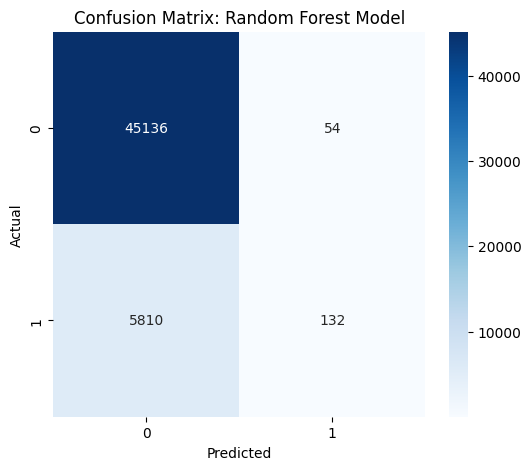

Precision (pos=1): 0.710
Recall    (pos=1): 0.022
F1 Score  (pos=1): 0.043
Overall accuracy: 0.885


In [ ]:
# For the latest RF model: Confusion Matrix, Precision, Recall, F1 Score, & Overall Accuracy

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation    import MulticlassClassificationEvaluator

# Score the test set
pred_final = final_model.transform(test_prepped)

# Build an RDD of (prediction, label) as floats
pred_label_rdd = (
    pred_final
      .select("prediction", "Default")
      .rdd
      .map(lambda r: (float(r[0]), float(r[1])))
)

# Compute confusion matrix + class metrics
metrics = MulticlassMetrics(pred_label_rdd)
cm = metrics.confusionMatrix().toArray()
# print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix: Random Forest Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision and recall for the positive class (1.0)
prec_pos = metrics.precision(1.0)
rec_pos  = metrics.recall(1.0)
f1_pos   = metrics.fMeasure(1.0)
print(f"Precision (pos=1): {prec_pos:.3f}")
print(f"Recall    (pos=1): {rec_pos:.3f}")
print(f"F1 Score  (pos=1): {f1_pos:.3f}")

# Overall accuracy
acc_evaluator = MulticlassClassificationEvaluator(
    labelCol="Default", predictionCol="prediction", metricName="accuracy"
)
accuracy = acc_evaluator.evaluate(pred_final)
print(f"Overall accuracy: {accuracy:.3f}")

## Limitations

All research is limited by time and scope and our project is no different. Our data analysis was limited due to the fact that the data we are using is from a single kaggle dataset that was last updated two years ago. This may not completely reflect the current market trends and borrower behaviour as the economy is in a much diffrent place now compared to two years ago.

We focused on a select group of models for our analysis, like Random Forest and Logistic Regression, which were effective but other methods like neural networks were not used due to time constraints.

One of the major limiting factors of this project was Colab and the sheer size of the dataset, which led to challenges in processing speed, memory allocation issues and overall workflow effeciency.

## Future Work

Next steps for this project could include expanding modeling to other suitable machine learning algorithms, such as k-Nearest Neighbors, Naive Bayes, Support Vector Machine (SVM), or neural networks. Continuing to fine tune model hyperparameters could also prove beneficial. In addition, expanding this project to test on other similiar loan portfolio datasets could help to further understand what actions need to be taken to increase model performance.

## Conclusion

Given the high-dimensional nature of the dataset, our initial approach was to use Principal Component Analysis (PCA) to capture enough variance in the data to use in a supervised algorithm, such as Logistic Regression or Random Forest Classification. Despite much effort and experimentation, however, at best, PCA was only able to capture a small amount of variances over several principal components (e.g., PC1 captured 9%, PC2 captured 8%, etc). We then turned to t-SNE visualization, but ultimately, it likewise did not prove helpful in the way we were hoping. The PCA results and t-SNE scatter plot showed that the data was not as linear as we were initially thinking, and that we may need to think about our approach more creatively.

Intuitively, it made sense that defaults would be more likely in loans that were higher in amount with higher interest rates, and those that were borrowed by individuals with unstable employment and/or income and poor credit history. This intuition matched the findings in our initial exploration, as well. We  engineered a Risk Score, which was comprised of the most important features found by the Random Forest algorithm (Loan Amount, Income, Interest and Credit Score). We also engineered and income-to-loan ratio and WOE (Weight of Evidence) features.

After exploring different supervised algorithms, we decided to move forward with the  best performer - Random Forest Classifier. Overall, this model had an Area Under Curve (AUC) score of 75.17% and an accuracy score of 88.6% on predicting default status. To help achieve this, a parameter grid builder was used to detect optimal parameters (i.e., number of trees and max depth) on a smaller subset of the data. Unfortunately, time constraints and Google Colab performance limited a deeper exploration and testing of hyperparameters.